In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


In [58]:
# Define dataset paths
train_path = './CNN_dataset/train'
test_path = './CNN_dataset/test'


In [64]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing for testing
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load data with flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Ensure class names are consistent between train and test
assert train_generator.class_indices == test_generator.class_indices, \
    "Mismatch in class names between train and test datasets."

# Class labels
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")


Found 50000 images belonging to 5 classes.
Found 50000 images belonging to 5 classes.
Classes: ['AbdomenCT', 'CXR', 'ChestCT', 'Hand', 'HeadCT']


In [65]:
# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Output layer matches the number of classes
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [66]:
# Train the model
epochs = 1
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 419s 268ms/step - accuracy: 0.8236 - loss: 0.4492 - val_accuracy: 0.9933 - val_loss: 0.0231


In [67]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9933 - loss: 0.0233
Test Loss: 0.0231, Test Accuracy: 0.9933


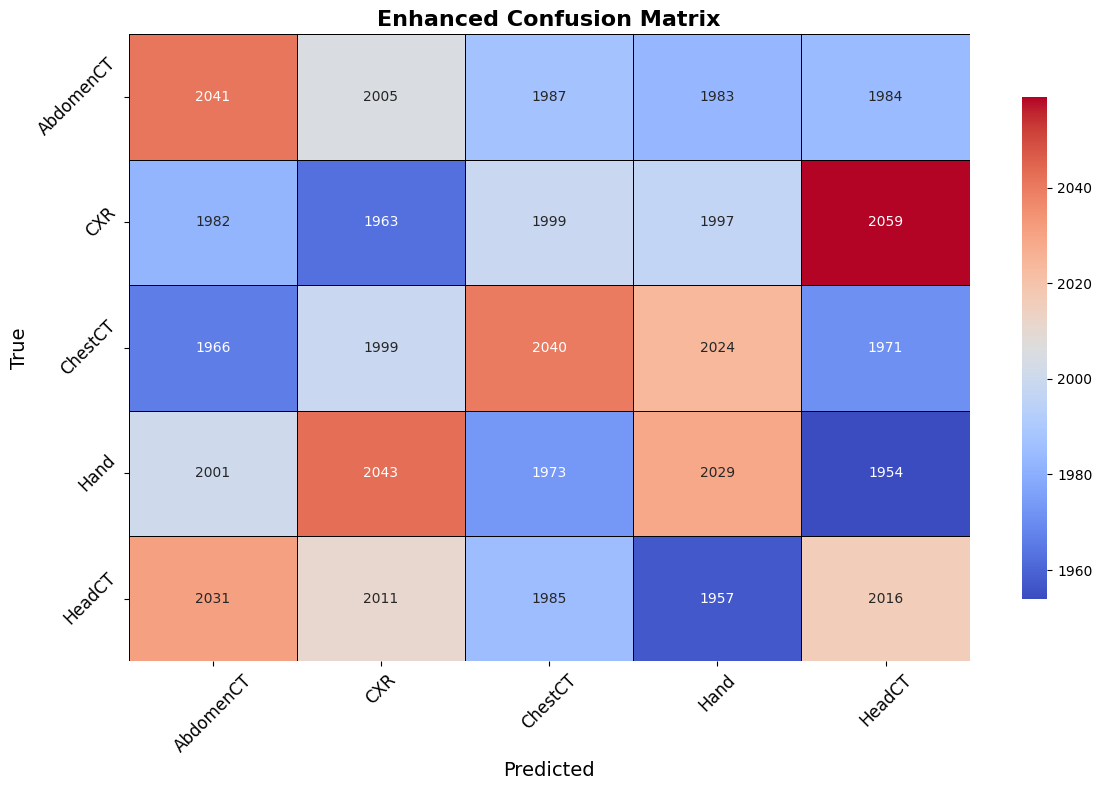

In [73]:
# Confusion matrix
plt.figure(figsize=(12, 8))

# Use seaborn heatmap with customized aesthetics
sns.heatmap(
    cm,
    annot=True,                  # Annotate the cell values
    fmt="d",                     # Format as integers
    cmap="coolwarm",             # Use a visually appealing colormap
    xticklabels=class_names,     # X-axis labels
    yticklabels=class_names,     # Y-axis labels
    linewidths=0.5,              # Add gridlines between cells
    linecolor="black",           # Color of gridlines
    cbar_kws={'shrink': 0.8}     # Shrink colorbar to fit plot
)

# Set plot titles and labels with larger font sizes
plt.title("Enhanced Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)

# Add a tight layout to reduce extra margins
plt.tight_layout()

# Display the plot
plt.show()


In [76]:
from sklearn.metrics import classification_report
import pandas as pd
from tabulate import tabulate

# Generate classification report as a dictionary
report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Convert dictionary to pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round values for cleaner formatting
report_df = report_df.round(2)

# Print the classification report as a styled table
print("Classification Report:\n")
print(tabulate(report_df, headers='keys', tablefmt='fancy_grid', showindex=True))


Classification Report:

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ AbdomenCT    │         0.2 │      0.2 │        0.2 │   10000   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ CXR          │         0.2 │      0.2 │        0.2 │   10000   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ChestCT      │         0.2 │      0.2 │        0.2 │   10000   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Hand         │         0.2 │      0.2 │        0.2 │   10000   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ HeadCT       │         0.2 │      0.2 │        0.2 │   10000   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │         0.2 │      0.2 │        0.2 │       0.2 │
├──────────────┼─────────────┼────────

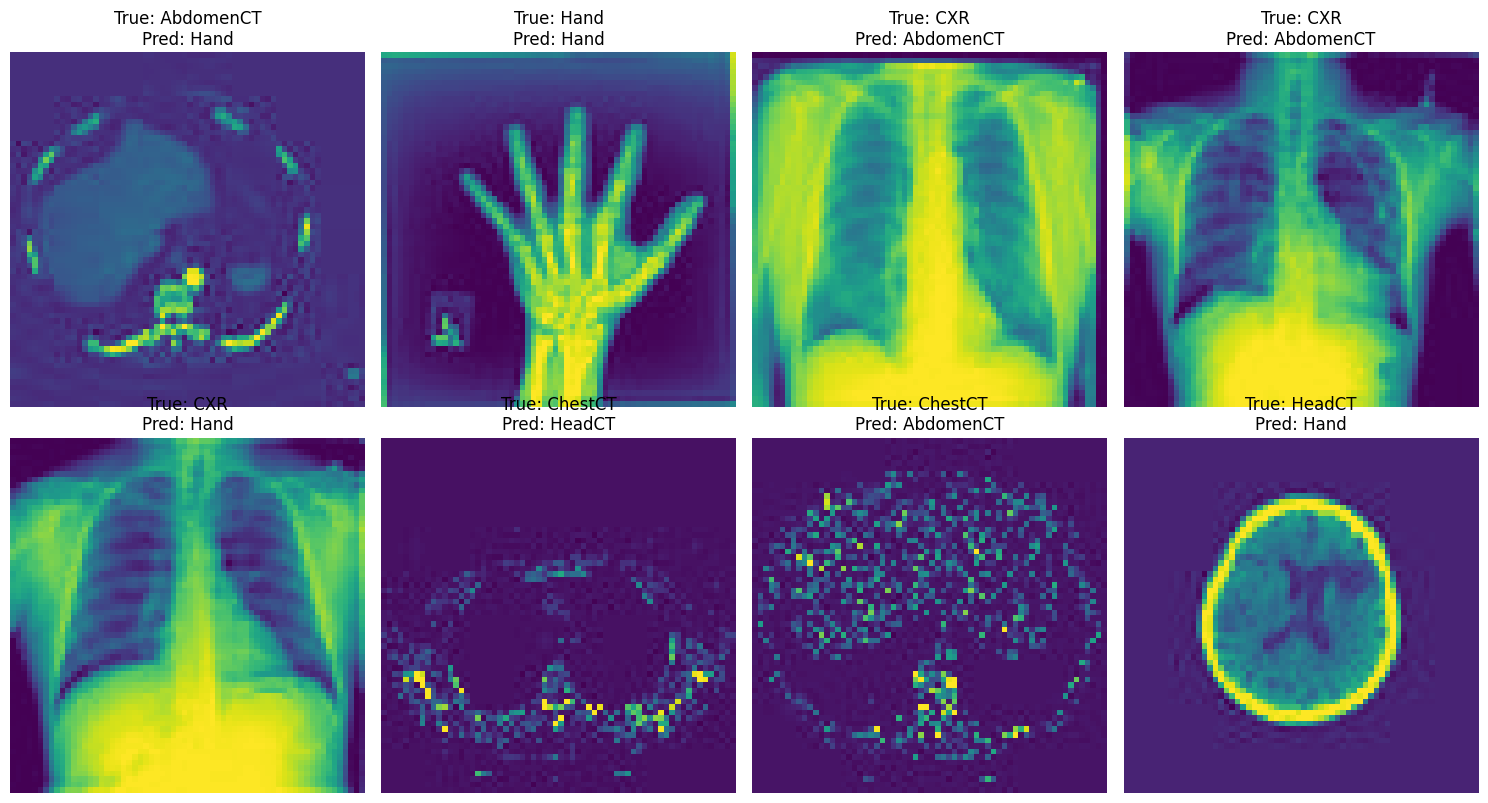

In [70]:
# Visualize random predictions
import random

# Select random indices
random_indices = random.sample(range(len(test_generator.filenames)), 8)
sample_files = [test_generator.filepaths[i] for i in random_indices]
sample_images = [plt.imread(f) for f in sample_files]
sample_labels = [y_true[i] for i in random_indices]
sample_preds = [y_pred_classes[i] for i in random_indices]

# Plot samples
plt.figure(figsize=(15, 8))
for i, (img, true_label, pred_label) in enumerate(zip(sample_images, sample_labels, sample_preds)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [72]:
# Save the model
model.save("cnn_model_tf_fixed.keras")
print("Model saved successfully!")


Model saved successfully!
